In [ ]:
%cd ../../auto-cat-crop/

In [ ]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
#model = models.vgg19(pretrained=True)
#model.eval()

In [ ]:
data_path = "./images/Abyssinian_1.jpg"

In [ ]:
img = Image.open(data_path)
img = img.convert("RGB")

In [ ]:
plt.imshow(img)

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model


In [ ]:
if device:
    input_batch = input_batch.to(device)
    model = model.to(device)

In [ ]:
%time
with torch.no_grad():
    for _ in range(10):
    
        output = model(input_batch)

In [ ]:
#print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
#print(torch.nn.functional.softmax(output[0], dim=0))
torch.argmax(output[0])


In [56]:
from cam.base_cam import ScoreCAM

In [57]:
vgg = models.vgg16(pretrained=True).eval()
vgg_model_dict = dict(type='vgg16', arch=vgg, layer_name='features_29',input_size=(224, 224))
vgg_scorecam = ScoreCAM(vgg_model_dict)

#input_image = load_image('images/'+'ILSVRC2012_val_00002193.JPEG')
#input_ = apply_transforms(input_image)
predicted_class = vgg(input_batch).max(1)[-1]



In [ ]:
%time
scorecam_map = vgg_scorecam(input_batch)

In [ ]:
scorecam_map.shape

In [ ]:
plt.imshow(scorecam_map[0][0])

In [58]:
from cam.base_cam import GradCAMpp

In [59]:
vgg_gradcam = GradCAMpp(vgg_model_dict)

In [60]:
%time
scorecam_map, logit = vgg_gradcam(input_batch)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [ ]:
print(scorecam_map.shape)

&lt;matplotlib.image.AxesImage at 0x7fca8da5ce20&gt;

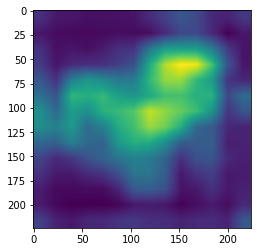

In [50]:
plt.imshow(scorecam_map[0][0])

&lt;matplotlib.image.AxesImage at 0x7fca8e466880&gt;

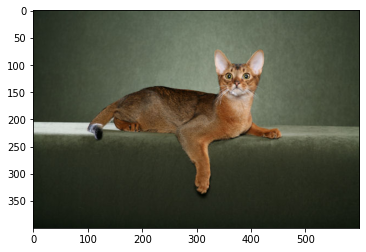

In [62]:
plt.imshow(img)

In [94]:
import numpy as np
height, width = 100, 200

4

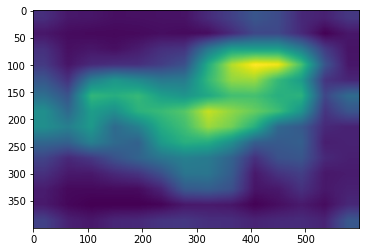

In [54]:
scorecam_scores = scorecam_map[0][0]
np_scorecam_map = scorecam_scores.numpy() * 255
im_scores = Image.fromarray(np_scorecam_map.astype(np.uint8))
plt.imshow(im_scores.resize((600, 400), Image.BILINEAR))
scorecam_map.dim()

&lt;matplotlib.image.AxesImage at 0x7fca8d89a460&gt;

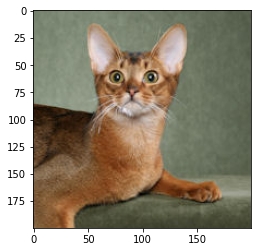

In [99]:
data_path = "./images/Abyssinian_1.jpg"
img = Image.open(data_path)
img = img.convert("RGB")

height, width = 200, 200
interpolation_mode = Image.BILINEAR

def cropping_picture(img, height, width):
    img_h, img_w = img.height, img.width
    height = min(height, img_h)
    width = min(width, img_w)

    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)
    scorecam_map, _ = vgg_gradcam(input_batch)
    scorecam_scores = scorecam_map[0][0]
    # uint8 にするために 255 を掛けた。
    np_scorecam_map = scorecam_scores.numpy() * 255
    im_scores = np.asarray(
        Image.fromarray(np_scorecam_map.astype(np.uint8)).resize((img_w, img_h), interpolation_mode))
    
    max_score = 0
    maxh, maxw = 0, 0
    ch, cw = 0, 0
    # 最大スコアの部分を探索
    for i in range(img_h - height + 1):  # 縦
        for j in range(img_w - width + 1):  # 横
            crop_score = im_scores[i : i + height, j : j + width].sum()
            if crop_score > max_score:
                max_score = crop_score
                maxh, maxw = i, j
                # cy = im_scores[]
        
    return img.crop((maxw, maxh, maxw + width, maxh + height))

plt.imshow(cropping_picture(img, height=height, width=width))

&lt;matplotlib.image.AxesImage at 0x7fca8c1bb790&gt;

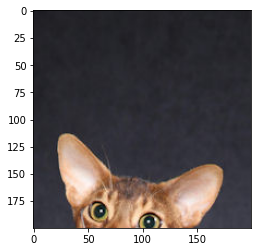

In [101]:
data_path = "./images/Abyssinian_3.jpg"
img = Image.open(data_path)
img = img.convert("RGB")

height, width = 200, 200
interpolation_mode = Image.BILINEAR

def cropping_picture(img, height, width):
    img_h, img_w = img.height, img.width
    height = min(height, img_h)
    width = min(width, img_w)

    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)
    scorecam_map, _ = vgg_gradcam(input_batch)
    scorecam_scores = scorecam_map[0][0]
    # uint8 にするために 255 を掛けた。
    np_scorecam_map = scorecam_scores.numpy() * 255
    im_scores = np.asarray(
        Image.fromarray(np_scorecam_map.astype(np.uint8)).resize((img_w, img_h), interpolation_mode))
    
    max_score = 0
    maxh, maxw = 0, 0
    ch, cw = 0, 0
    # 最大スコアの部分を探索
    for i in range(img_h - height + 1):  # 縦
        for j in range(img_w - width + 1):  # 横
            tmp_crop = im_scores[i : i + height, j : j + width]
            crop_score = tmp_crop.sum()
            if crop_score > max_score:
                max_score = crop_score
                maxh, maxw = i, j
                ch = tmp_crop.max(axis=1).argmax()
                cw = tmp_crop[ch].argmax()
                ch += i
                cw += j
    
    ch = max(ch, height // 2)
    cw = max(cw, width // 2)
    ch = min(ch, img_h - height // 2)
    cw = min(cw, img_w - width // 2)

    return img.crop((cw - width // 2, ch - height // 2, cw + width // 2, ch + height // 2))

plt.imshow(cropping_picture(img, height=height, width=width))